# Multi Color Light Curves  applied LSSTComCamSim


based on notebook from Lauren macArthur


- author Sylvie Dagoret-Campagne
- creation date 2024-04-10
- last update 2024-04-10


  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize']= 'large'
plt.rcParams['ytick.labelsize']= 'large'

In [3]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [4]:
saveDir = "./lc_output_dmrehearsal2024"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [5]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux =  100

In [6]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collectionn = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
#collections = [collection1,collection2,collection3]
collections = [collection2]
collectionStr = collectionn.replace("/", "_")
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
#3533 : No matching visitId
tract = 2494
#band = "r"
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

calibFluxStr = "apFlux_12_0_instFlux"
calibFluxErrStr = "apFlux_12_0_instFluxErr"
calibFluxMagStr = "apFlux_12_0_instMag"
calibFluxMagErrStr = "apFlux_12_0_instMagErr"

calibFluxCalStr = "apFlux_12_0_calFlux"
calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
calibFluxCalMagStr = "apFlux_12_0_calMag"
calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

file_output_selectedsources = f"lightcurves-dmrehearsal2024_04_03_tract{tract}.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Initiate butler from variables set above

In [7]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LSSTComCamSim
collections = ['LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612']


## load isolated_star_sources

In [8]:
# Try to get the Schema
all_tracts = []
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= where_clause)
for i, ref in enumerate(datasetRefs):
    print(i,ref.dataId)
    all_tracts.append(ref.dataId["tract"])
    #butler_data = butler.get(ref)

all_tracts = sorted(all_tracts)
print("all tracts : ", all_tracts)

#if not isinstance(butler_data, pd.core.frame.DataFrame):
#    print(butler_data.getSchema())

0 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494}
1 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495}
2 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2661}
3 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2662}
4 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3200}
5 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3345}
6 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3346}
7 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3533}
8 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3534}
9 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 6914}
10 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 6915}
11 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 7148}
12 {instrument: 'LSSTComCamSim', skyma

## isolated_star_sources Keeping all bands here, but keep the tract selection

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [9]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [10]:
tract

2494

In [11]:
len(isolatedStarSourcesFull)

664704

In [12]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index
0,99325,3065474226484936866,7024040300581,7,279.868189,-48.063642,i_06,i,20825.896484,621.281189,3656.229531,69.944283,0.022153,0.022196,20419.768999,879.22988,False,0.239154,False,1.825126,1.816471,0.009507,99325,0


In [13]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index
0,99325,3065474226484936866,7024040300581,7,279.868189,-48.063642,i_06,i,20825.896484,621.281189,3656.229531,69.944283,0.022153,0.022196,20419.768999,879.229880,False,0.239154,False,1.825126,1.816471,0.009507,99325,0
1,105385,3065474227558684913,7024040300582,7,279.868196,-48.063645,i_06,i,20513.070312,621.842896,1154.947901,2758.247871,0.022588,0.021572,21523.310571,880.180357,False,0.254727,False,1.860208,1.774970,-0.005804,105385,0
2,99478,3065474228632420428,7024040300583,7,279.868183,-48.063642,i_06,i,19191.630859,631.030823,434.090032,36.309856,0.023069,0.023109,18530.540675,894.783943,False,-0.643387,False,1.817381,1.879033,-0.054907,99478,0
3,101480,3065474229706169087,7024040300584,7,279.868186,-48.063643,i_06,i,19648.865234,618.939209,715.767385,3143.944998,0.023796,0.024680,19133.695969,875.697264,False,-0.334094,False,1.933969,2.048853,0.078023,101480,0
4,98012,3065474230779906996,7024040300585,7,279.868187,-48.063643,i_06,i,20019.126953,647.828674,1590.989654,1500.417290,0.027849,0.027534,18883.463567,918.737462,False,-2.123127,False,2.258469,2.286982,0.012919,98012,0


In [14]:
isolatedStarSourcesFull.tail()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index
664699,212,3065474223234351317,7024040300578,0,279.064987,-47.880712,g_01,g,17784.931641,447.129883,177.614192,142.160237,0.024478,0.025717,18222.380251,630.131527,False,0.949386,False,2.375214,2.542768,0.199471,212,28599
664700,193,3065474223234351298,7024040300578,0,279.093273,-47.871926,g_01,g,24576.859375,462.928650,553.418365,128.943838,0.019357,0.019739,24368.411690,649.409041,False,0.284536,False,2.427044,2.431681,0.273162,193,28600
664701,185,3065474223234351290,7024040300578,0,279.077563,-47.876195,g_01,g,15114.945312,445.442047,348.959883,126.144155,0.029670,0.029527,15337.927126,627.749099,False,0.547065,False,2.496540,2.521481,0.305903,185,28601
664702,164,3065474223234351269,7024040300578,0,279.097150,-47.869809,g_01,g,120865.101562,521.513184,611.310686,112.018645,0.007122,0.007080,121556.533508,692.685787,False,0.635554,False,2.445363,2.374502,0.244708,164,28602
664703,163,3065474223234351268,7024040300578,0,279.063103,-47.879411,g_01,g,93753.273438,495.451202,165.743269,111.783884,0.008379,0.008220,94105.769127,665.531272,False,0.787353,False,2.513831,2.418630,0.241959,163,28603


In [15]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_12_0_instFlux',
       'apFlux_12_0_instFluxErr', 'x', 'y', 'xErr', 'yErr',
       'apFlux_17_0_instFlux', 'apFlux_17_0_instFluxErr', 'apFlux_17_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'ixx', 'iyy', 'ixy',
       'source_row', 'obj_index'],
      dtype='object')

In [16]:
print(sorted(isolatedStarSourcesFull["visit"].unique()))

[7024040300541, 7024040300542, 7024040300543, 7024040300544, 7024040300545, 7024040300546, 7024040300547, 7024040300548, 7024040300549, 7024040300550, 7024040300551, 7024040300552, 7024040300554, 7024040300555, 7024040300557, 7024040300558, 7024040300559, 7024040300560, 7024040300561, 7024040300562, 7024040300563, 7024040300564, 7024040300565, 7024040300566, 7024040300567, 7024040300568, 7024040300569, 7024040300570, 7024040300571, 7024040300572, 7024040300573, 7024040300574, 7024040300575, 7024040300576, 7024040300577, 7024040300578, 7024040300579, 7024040300580, 7024040300581, 7024040300582, 7024040300583, 7024040300584, 7024040300585, 7024040300586, 7024040300587, 7024040300588, 7024040300589, 7024040300590, 7024040300591, 7024040300592, 7024040300593, 7024040300594, 7024040300595, 7024040300596, 7024040300597, 7024040300598, 7024040300599, 7024040300600, 7024040300662, 7024040300663, 7024040300665, 7024040300666, 7024040300667, 7024040300668, 7024040300669, 7024040300670, 702404030

In [17]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index
0,99325,3065474226484936866,7024040300581,7,279.868189,-48.063642,i_06,i,20825.896484,621.281189,3656.229531,69.944283,0.022153,0.022196,20419.768999,879.22988,False,0.239154,False,1.825126,1.816471,0.009507,99325,0


In [18]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_12_0_instFlux,,minSnCalibFlux = 100, minNumMatches = 3


## Select a number of visits with enough good sources but in all bands here

- extract the list of known objects

In [19]:
calibFluxStr

'apFlux_12_0_instFlux'

In [20]:
minSnCalibFlux

100

In [21]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
# loop on object having sources with S/N aboe selection 
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched sources from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_12_0_instFlux > 100 (leaving N=231582 matched sources from original 664704)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 8308 objects from 28604).


In [22]:
sorted_visitList = sorted(visitList)
sorted_visitList 

[7024040300541,
 7024040300542,
 7024040300543,
 7024040300544,
 7024040300545,
 7024040300546,
 7024040300547,
 7024040300548,
 7024040300549,
 7024040300550,
 7024040300551,
 7024040300552,
 7024040300554,
 7024040300555,
 7024040300557,
 7024040300558,
 7024040300559,
 7024040300560,
 7024040300561,
 7024040300562,
 7024040300563,
 7024040300564,
 7024040300565,
 7024040300566,
 7024040300567,
 7024040300568,
 7024040300569,
 7024040300570,
 7024040300571,
 7024040300572,
 7024040300573,
 7024040300574,
 7024040300575,
 7024040300576,
 7024040300577,
 7024040300578,
 7024040300579,
 7024040300580,
 7024040300581,
 7024040300582,
 7024040300583,
 7024040300584,
 7024040300585,
 7024040300586,
 7024040300587,
 7024040300588,
 7024040300589,
 7024040300590,
 7024040300591,
 7024040300592,
 7024040300593,
 7024040300594,
 7024040300595,
 7024040300596,
 7024040300597,
 7024040300598,
 7024040300599,
 7024040300600,
 7024040300662,
 7024040300663,
 7024040300665,
 7024040300666,
 7024040

In [23]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [24]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [25]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [26]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

## Note that some sourceTable_visit not found for some visits in isolated_star_sources 

In [27]:
visitList

[7024040300544,
 7024040300545,
 7024040300546,
 7024040300547,
 7024040300548,
 7024040300549,
 7024040300550,
 7024040300551,
 7024040300552,
 7024040300554,
 7024040300555,
 7024040300557,
 7024040300558,
 7024040300559,
 7024040300560,
 7024040300561,
 7024040300562,
 7024040300563,
 7024040300564,
 7024040300565,
 7024040300566,
 7024040300567,
 7024040300568,
 7024040300569,
 7024040300570,
 7024040300571,
 7024040300572,
 7024040300573,
 7024040300574,
 7024040300575,
 7024040300576,
 7024040300577,
 7024040300578,
 7024040300579,
 7024040300580,
 7024040300581,
 7024040300582,
 7024040300583,
 7024040300584,
 7024040300585,
 7024040300586,
 7024040300587,
 7024040300588,
 7024040300589,
 7024040300590,
 7024040300591,
 7024040300592,
 7024040300593,
 7024040300594,
 7024040300595,
 7024040300596,
 7024040300597,
 7024040300598,
 7024040300599,
 7024040300600,
 7024040300662,
 7024040300663,
 7024040300665,
 7024040300666,
 7024040300667,
 7024040300668,
 7024040300669,
 7024040

In [28]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 7024040300584
sourceTable_visit not found for visit 7024040300680
sourceTable_visit not found for visit 7024040300690
sourceTable_visit not found for visit 7024040300692
sourceTable_visit not found for visit 7024040300694
sourceTable_visit not found for visit 7024040300699
sourceTable_visit not found for visit 7024040300700
sourceTable_visit not found for visit 7024040300720
Number of objects with >=3 matches before sourceTable_visit exsistence check: 8308
Number of objects with >=3 matches after sourceTable_visit exsistence check: 8215


In [29]:
len(sourceCatalogs)

101

In [30]:
nSourceDict

{7024040300544: 85819,
 7024040300545: 90856,
 7024040300546: 86337,
 7024040300547: 86839,
 7024040300548: 83696,
 7024040300549: 82723,
 7024040300550: 77347,
 7024040300551: 79924,
 7024040300552: 80640,
 7024040300554: 85322,
 7024040300555: 85448,
 7024040300557: 81661,
 7024040300558: 87482,
 7024040300559: 86242,
 7024040300560: 90085,
 7024040300561: 69075,
 7024040300562: 68166,
 7024040300563: 67012,
 7024040300564: 67671,
 7024040300565: 65989,
 7024040300566: 66820,
 7024040300567: 67548,
 7024040300568: 68547,
 7024040300569: 67311,
 7024040300570: 65132,
 7024040300571: 66071,
 7024040300572: 67098,
 7024040300573: 68490,
 7024040300574: 67255,
 7024040300575: 65899,
 7024040300576: 69172,
 7024040300577: 68456,
 7024040300578: 70953,
 7024040300579: 69754,
 7024040300580: 69474,
 7024040300581: 108758,
 7024040300582: 109285,
 7024040300583: 108952,
 7024040300585: 103266,
 7024040300586: 102835,
 7024040300587: 104792,
 7024040300588: 100750,
 7024040300589: 98553,
 702

In [31]:
visitList

[7024040300544,
 7024040300545,
 7024040300546,
 7024040300547,
 7024040300548,
 7024040300549,
 7024040300550,
 7024040300551,
 7024040300552,
 7024040300554,
 7024040300555,
 7024040300557,
 7024040300558,
 7024040300559,
 7024040300560,
 7024040300561,
 7024040300562,
 7024040300563,
 7024040300564,
 7024040300565,
 7024040300566,
 7024040300567,
 7024040300568,
 7024040300569,
 7024040300570,
 7024040300571,
 7024040300572,
 7024040300573,
 7024040300574,
 7024040300575,
 7024040300576,
 7024040300577,
 7024040300578,
 7024040300579,
 7024040300580,
 7024040300581,
 7024040300582,
 7024040300583,
 7024040300585,
 7024040300586,
 7024040300587,
 7024040300588,
 7024040300589,
 7024040300590,
 7024040300591,
 7024040300592,
 7024040300593,
 7024040300594,
 7024040300595,
 7024040300596,
 7024040300597,
 7024040300598,
 7024040300599,
 7024040300600,
 7024040300662,
 7024040300663,
 7024040300665,
 7024040300666,
 7024040300667,
 7024040300668,
 7024040300669,
 7024040300670,
 7024040

In [32]:
visitsToRemove 

[7024040300584,
 7024040300680,
 7024040300690,
 7024040300692,
 7024040300694,
 7024040300699,
 7024040300700,
 7024040300720]

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### add my info from CCD Visit Table

- CCD visit table is a pre-FGCM calibration
- it provides airmass and initial zero-point

In [33]:
# need also. ["zeroPoint","airmass"]

In [34]:
# Collect useful columns from ccdVisitTable
visitsCCDToRemove = []


ccdVisitTable = butler.get("ccdVisitTable")
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + 
                                    ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)
psfSigmaDict = {}
skyBgDict = {}
skyNoiseDict = {}
expTimeDict = {}
expMidptMjdDict = {}
medianEDict = {}
psfStarScaledDeltaSizeScatterDict = {}
astromOffsetStdDict = {}
psfTraceRadiusDeltaDict = {}
zeroPointDict = {}
airmassDict = {}
seeingDict = {}
#localCalibDict = {}
#DZPDict = {}
# for visit in ccdVisitTable["visitId"].values:
#     if visit in visitList:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
        skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
        skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
        expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
        expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
        medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
        psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
        astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
        psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
        zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
        airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
        seeingDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["seeing"].values[0]
#        DZPDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["DZP"].values[0]
    else:
        #raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))
        print("ERROR: CCD visit {} not found in ccdVisitTable".format(visit))
        visitsCCDToRemove.append(visit) 
        psfSigmaDict[visit] = np.nan
        skyBgDict[visit] = np.nan
        skyNoiseDict[visit] = np.nan
        expTimeDict[visit] = np.nan
        expMidptMjdDict[visit] = np.nan
        medianEDict[visit] = np.nan
        psfStarScaledDeltaSizeScatterDict[visit] = np.nan
        astromOffsetStdDict[visit] = np.nan
        psfTraceRadiusDeltaDict[visit] = np.nan
        zeroPointDict[visit] = np.nan
        airmassDict[visit] = np.nan
        seeingDict[visit] = np.nan

In [35]:
visitList

[7024040300544,
 7024040300545,
 7024040300546,
 7024040300547,
 7024040300548,
 7024040300549,
 7024040300550,
 7024040300551,
 7024040300552,
 7024040300554,
 7024040300555,
 7024040300557,
 7024040300558,
 7024040300559,
 7024040300560,
 7024040300561,
 7024040300562,
 7024040300563,
 7024040300564,
 7024040300565,
 7024040300566,
 7024040300567,
 7024040300568,
 7024040300569,
 7024040300570,
 7024040300571,
 7024040300572,
 7024040300573,
 7024040300574,
 7024040300575,
 7024040300576,
 7024040300577,
 7024040300578,
 7024040300579,
 7024040300580,
 7024040300581,
 7024040300582,
 7024040300583,
 7024040300585,
 7024040300586,
 7024040300587,
 7024040300588,
 7024040300589,
 7024040300590,
 7024040300591,
 7024040300592,
 7024040300593,
 7024040300594,
 7024040300595,
 7024040300596,
 7024040300597,
 7024040300598,
 7024040300599,
 7024040300600,
 7024040300662,
 7024040300663,
 7024040300665,
 7024040300666,
 7024040300667,
 7024040300668,
 7024040300669,
 7024040300670,
 7024040

In [36]:
visitsToRemove 

[7024040300584,
 7024040300680,
 7024040300690,
 7024040300692,
 7024040300694,
 7024040300699,
 7024040300700,
 7024040300720]

In [37]:
# Just to have a look at what's in the catalog:
ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
730865860864,7024040300001,r_03,r,124.617999,-15.026212,17.825243,31.258871,1.507056,1703.767822,34.47179,0.005423,0.003085,534,0.000671,0.000063,0.010385,0.010232,-0.001001,0.009205,0.006108,0.012708,343.330109,11.789084,1.127149,0.344765,1.01124,-15.026212,0,0.71116,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.458471,-15.063877,124.581823,-14.871498,124.777487,-14.988434,124.654231,-15.180921,1.050426,0.000674


### Plot visits versus time

In [38]:
ccdVisitTable_subset = ccdVisitTable[["visitId","band","zeroPoint","psfSigma","skyBg","skyNoise","seeing","expMidptMJD","obsStart","airmass","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec"]]

#### compute nightObs and datetime time

In [39]:
ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])

/tmp/ipykernel_72104/2382442427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
/tmp/ipykernel_72104/2382442427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])


In [40]:
ccdVisitTable_g = ccdVisitTable_subset[ccdVisitTable_subset.band== "g"]
ccdVisitTable_r = ccdVisitTable_subset[ccdVisitTable_subset.band== "r"]
ccdVisitTable_i = ccdVisitTable_subset[ccdVisitTable_subset.band== "i"]
#ccdVisitTable_z = ccdVisitTable_subset[ccdVisitTable_subset.band== "z"]
#ccdVisitTable_y = ccdVisitTable_subset[ccdVisitTable_subset.band== "y"]

In [41]:
ccdVisitTable_subset.head()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,
730865860864,7024040300001,r,31.258871,1.507056,1703.767822,34.471790,0.711160,60403.979509,2024-04-03 23:30:14.555496,1.050426,124.458471,-15.063877,124.581823,-14.871498,124.777487,-14.988434,124.654231,-15.180921,20240403,2024-04-03 23:30:14.555496
730865860865,7024040300001,r,31.238535,1.508598,1674.763306,32.659889,0.710764,60403.979509,2024-04-03 23:30:14.555496,1.051820,124.586453,-14.864268,124.709592,-14.671812,124.905148,-14.788632,124.782113,-14.981198,20240403,2024-04-03 23:30:14.555496
730865860866,7024040300001,r,31.259706,1.525470,1709.555664,33.396534,0.718461,60403.979509,2024-04-03 23:30:14.555496,1.053236,124.714213,-14.664580,124.837124,-14.472080,125.032570,-14.588777,124.909767,-14.781395,20240403,2024-04-03 23:30:14.555496
730865860867,7024040300001,r,31.267454,1.514115,1717.083984,34.223988,0.713278,60403.979509,2024-04-03 23:30:14.555496,1.050393,124.665250,-15.187500,124.788499,-14.995008,124.984403,-15.111770,124.861257,-15.304366,20240403,2024-04-03 23:30:14.555496
730865860868,7024040300001,r,31.265049,1.510671,1714.527710,33.346077,0.711782,60403.979509,2024-04-03 23:30:14.555496,1.051787,124.793126,-14.987773,124.916155,-14.795198,125.111945,-14.911856,124.989026,-15.104533,20240403,2024-04-03 23:30:14.555496


In [42]:
ccdVisitTable_subset.tail()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,
730866060292,7024040300780,r,31.276102,1.663994,1544.489258,31.839106,0.784160,60404.436044,2024-04-04 10:27:39.199510,1.063331,299.648263,-40.863270,299.855183,-40.699906,300.067595,-40.853432,299.860717,-41.017175,20240403,2024-04-04 10:27:39.199510
730866060293,7024040300780,r,31.241217,1.658965,1498.435913,32.142555,0.781568,60404.436044,2024-04-04 10:27:39.199510,1.063830,299.862940,-40.693761,300.068800,-40.530029,300.281152,-40.683155,300.075350,-40.847272,20240403,2024-04-04 10:27:39.199510
730866060294,7024040300780,r,31.276382,1.663328,1540.607056,32.586014,0.782899,60404.436044,2024-04-04 10:27:39.199510,1.064358,299.656968,-41.195332,299.864904,-41.031966,300.078406,-41.185459,299.870518,-41.349193,20240403,2024-04-04 10:27:39.199510
730866060295,7024040300780,r,31.260756,1.658629,1523.149414,31.984844,0.781810,60404.436044,2024-04-04 10:27:39.199510,1.064839,299.872697,-41.025821,300.079575,-40.862055,300.293012,-41.015162,300.086197,-41.179299,20240403,2024-04-04 10:27:39.199510
730866060296,7024040300780,r,31.251465,1.658580,1514.597778,32.967434,0.780872,60404.436044,2024-04-04 10:27:39.199510,1.065340,300.087328,-40.855895,300.293126,-40.691757,300.506492,-40.844470,300.300763,-41.008987,20240403,2024-04-04 10:27:39.199510


In [43]:
# function of time conversion
from astropy.time import Time

def dt_to_mjd(dt):
    t = Time(dt)
    return t.to_value('mjd','float')

def mjd_to_dt(mjd):
    tm = Time(mjd, format='mjd')
    # Convert to datetime
    utc =tm.to_datetime()
    return utc

In [44]:
dt = ccdVisitTable_subset.iloc[0]['Time']
dt

Timestamp('2024-04-03 23:30:14.555496')

In [45]:
type(dt)

pandas._libs.tslibs.timestamps.Timestamp

In [46]:
mjd = dt_to_mjd(dt)
mjd

60403.97933513306

In [47]:
tm = mjd_to_dt(mjd)

In [48]:
#ax.secondary_xaxis?

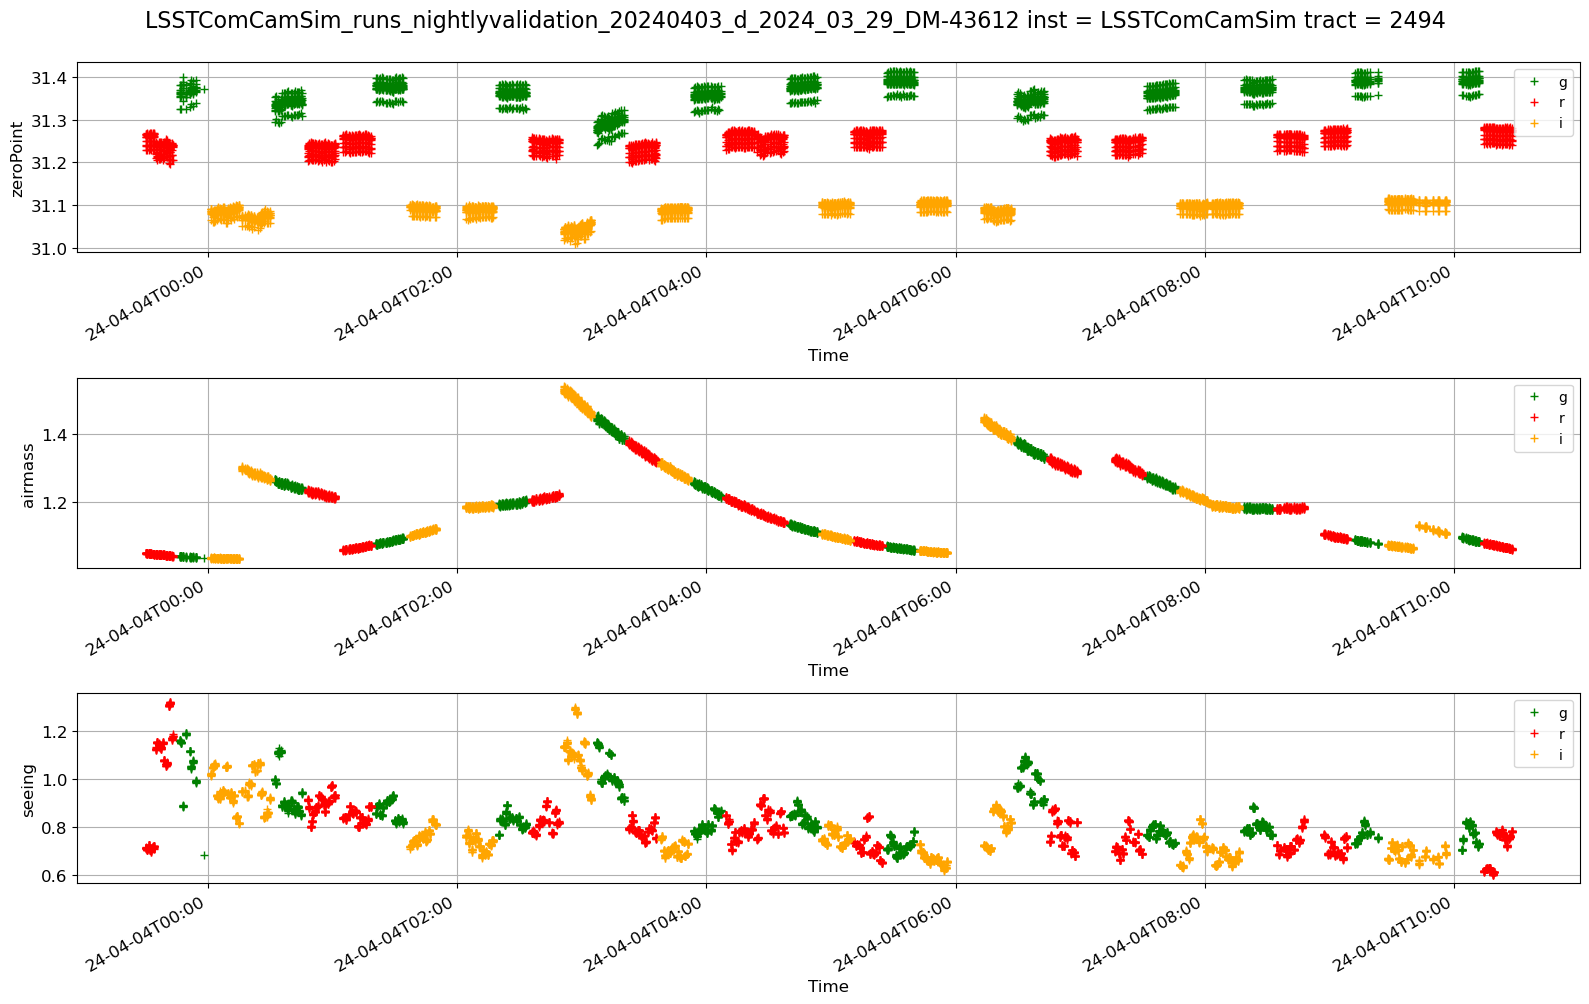

In [49]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

fig,axs = plt.subplots(3,1,figsize=(16,10))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
#ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
#ax1.set_title("zeroPoint")
ax1.set_ylabel("zeroPoint")
ax1.xaxis.set_major_formatter(date_form)
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")


ccdVisitTable_g.plot(x="Time",y="airmass",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="airmass",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="airmass",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="airmass",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
#ccdVisitTable_y.plot(x="Time",y="airmass",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
#ax2.set_title("airmass")
ax2.set_ylabel("airmass")
ax2.xaxis.set_major_formatter(date_form)

ccdVisitTable_g.plot(x="Time",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
#ccdVisitTable_y.plot(x="Time",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
#ax2.set_title("airmass")
ax3.set_ylabel("seeing")
ax3.xaxis.set_major_formatter(date_form)




#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()



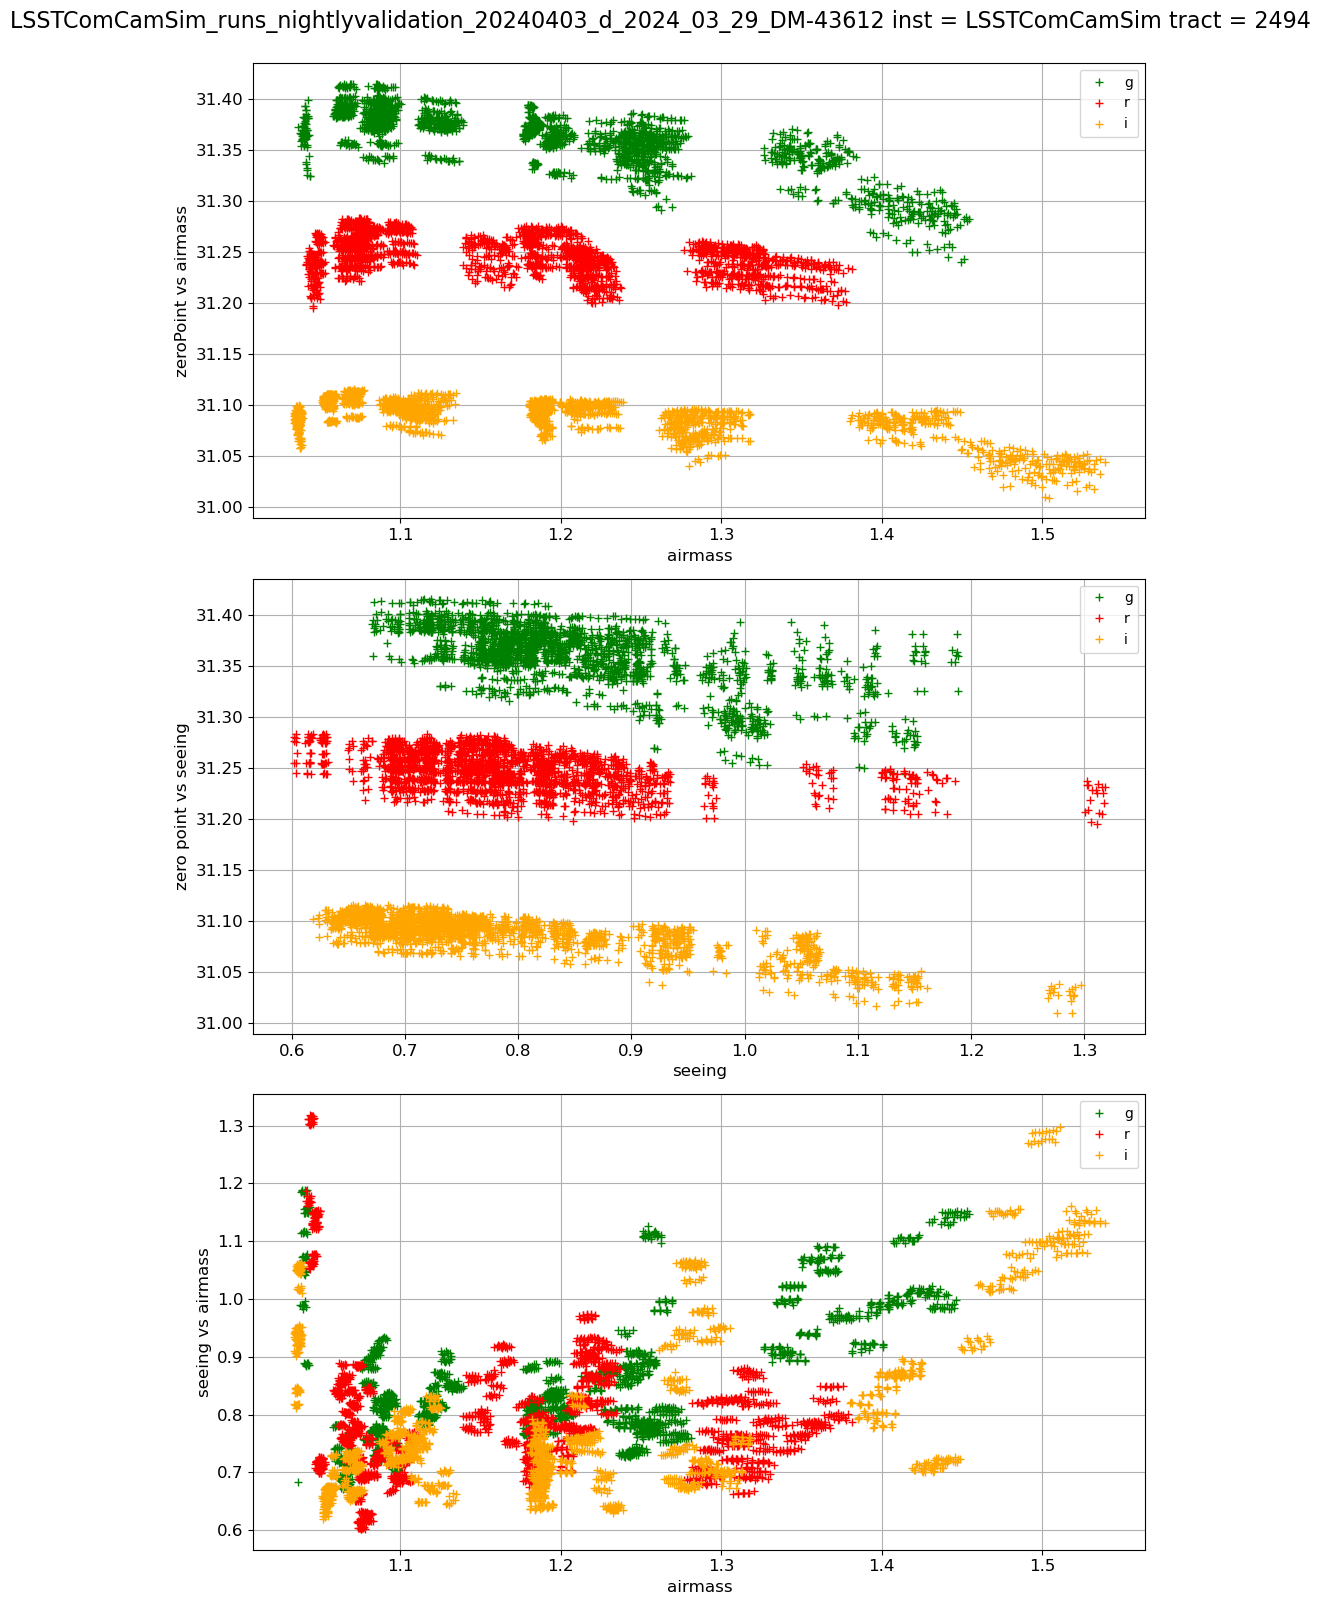

In [50]:
fig,axs = plt.subplots(3,1,figsize=(10,16))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="airmass",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
#ccdVisitTable_z.plot(x="airmass",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
#ccdVisitTable_y.plot(x="airmass",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
#ax1.set_title("zeroPoint")
ax1.set_ylabel("zeroPoint vs airmass")
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")

ccdVisitTable_g.plot(x="seeing",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="seeing",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="seeing",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
#ccdVisitTable_z.plot(x="seeing",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
#ccdVisitTable_y.plot(x="seeing",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
#ax2.set_title("airmass")
ax2.set_ylabel("zero point vs seeing")

ccdVisitTable_g.plot(x="airmass",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
#ccdVisitTable_z.plot(x="airmass",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
#ccdVisitTable_y.plot(x="airmass",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
#ax2.set_title("airmass")
ax3.set_ylabel("seeing vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Come-back to dataJoined

In [51]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_12_0_instFlux',
       'apFlux_12_0_instFluxErr', 'x', 'y', 'xErr', 'yErr',
       'apFlux_17_0_instFlux', 'apFlux_17_0_instFluxErr', 'apFlux_17_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'ixx', 'iyy', 'ixy',
       'source_row', 'obj_index'],
      dtype='object')

In [52]:
#calibFluxStr = "apFlux_12_0_instFlux"
#calibFluxErrStr = "apFlux_12_0_instFluxErr"
#calibFluxMagStr = "apFlux_12_0_instMag"
#calibFluxMagErrStr = "apFlux_12_0_instMagErr"

#calibFluxCalStr = "apFlux_12_0_calFlux"
#calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
#calibFluxCalMagStr = "apFlux_12_0_calMag"
#calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

In [53]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

#dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
#dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

#dataJoined[calibFluxStr] = (dataJoined[calibFluxStr].values*u.nJy).to(u.ABmag).value
#dataJoined[calibFluxStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxStr].values/dataJoined[calibFluxStr].values)
dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]
dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
#dataJoined["localPhotoCalib"] = dataJoined.apply(lambda x: localPhotoCalibDict[x["visit"]], axis=1)
dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)
dataJoined["seeing"] = dataJoined.apply(lambda x: seeingDict[x["visit"]], axis=1)
#dataJoined["DZP"] = dataJoined.apply(lambda x: DZPDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [54]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_12_0_calFlux,apFlux_12_0_calFluxErr,apFlux_12_0_calMag,apFlux_12_0_calMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,seeing
0,3065474186727129163,86352.630263,343.423668,False,0.997264,0.0,0.0,True,False,86489.062244,389.563021,False,1.149911,0.000253,False,74,7024040300544,0,279.618643,-47.84183,r_03,r,74523.492188,585.486816,1133.34122,49.511971,0.009525,0.009359,75142.562976,809.938955,False,2.240031,False,2.173527,2.154956,0.118756,74,6981,251.446357,19.059311,0.004318,85695.415844,673.257985,19.067606,0.00853,19.210972,0.998423,1.469387,805.57782,30.0,60404.30477,85819,0.000123,0.006708,0.002748,0.010058,31.247652,1.315659,0.69262


## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [55]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [56]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_12_0_calFlux,apFlux_12_0_calFluxErr,apFlux_12_0_calMag,apFlux_12_0_calMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,seeing,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,3065474186727129163,86352.630263,343.423668,False,0.997264,0.0,0.0,True,False,86489.062244,389.563021,False,1.149911,0.000253,False,74,7024040300544,0,279.618643,-47.84183,r_03,r,74523.492188,585.486816,1133.34122,49.511971,0.009525,0.009359,75142.562976,809.938955,False,2.240031,False,2.173527,2.154956,0.118756,74,6981,251.446357,19.059311,0.004318,85695.415844,673.257985,19.067606,0.00853,19.210972,0.998423,1.469387,805.57782,30.0,60404.30477,85819,0.000123,0.006708,0.002748,0.010058,31.247652,1.315659,0.69262,-59.472362,-1.880536,10.08548,1.043184,10.543113


In [57]:
dataJoined.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_12_0_instFlux,apFlux_12_0_instFluxErr,x,y,xErr,yErr,apFlux_17_0_instFlux,apFlux_17_0_instFluxErr,apFlux_17_0_flag,localBackground_instFlux,localBackground_flag,ixx,iyy,ixy,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_12_0_calFlux,apFlux_12_0_calFluxErr,apFlux_12_0_calMag,apFlux_12_0_calMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,seeing,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,3065474186727129163,86352.630263,343.423668,False,0.997264,0.0,0.0,True,False,86489.062244,389.563021,False,1.149911,0.000253,False,74,7024040300544,0,279.618643,-47.841830,r_03,r,74523.492188,585.486816,1133.341220,49.511971,0.009525,0.009359,75142.562976,809.938955,False,2.240031,False,2.173527,2.154956,0.118756,74,6981,251.446357,19.059311,0.004318,85695.415844,673.257985,19.067606,0.008530,19.210972,0.998423,1.469387,805.57782,30.0,60404.30477,85819,0.000123,0.006708,0.002748,0.010058,31.247652,1.315659,0.69262,-59.472362,-1.880536,10.085480,1.043184,10.543113
1,3065474186727129197,271502.836115,559.213775,False,0.996407,0.0,0.0,True,False,271045.523679,602.357251,False,1.149843,0.000253,False,108,7024040300544,0,279.571242,-47.867834,r_03,r,235866.250000,647.441223,394.436554,67.906204,0.004729,0.004773,235919.239465,841.260489,False,0.885346,False,2.175947,2.131584,0.077974,108,6781,485.508134,17.815564,0.002236,271209.059682,744.455493,17.816740,0.002980,17.967160,1.001687,1.469387,805.57782,30.0,60404.30477,85819,0.000123,0.006708,0.002748,0.010058,31.247652,1.315659,0.69262,-65.538373,-1.749445,-6.297338,-2.029341,-11.567875
2,3065474186727129203,141491.975535,419.970572,False,0.998635,0.0,0.0,True,False,143010.959664,509.324189,False,1.150249,0.000253,False,114,7024040300544,0,279.701450,-47.800154,r_03,r,123315.273438,617.954712,2383.222187,72.111413,0.007018,0.006967,123525.561704,837.931714,False,0.857274,False,2.227604,2.179145,0.108400,114,3396,336.909262,18.523170,0.003223,141843.307550,710.801978,18.520478,0.005441,18.675150,0.989379,1.469387,805.57782,30.0,60404.30477,85819,0.000123,0.006708,0.002748,0.010058,31.247652,1.315659,0.69262,-79.319863,-2.924276,1.267275,0.472744,3.631216
3,3065474186727129239,626233.665559,841.874435,False,0.998196,0.0,0.0,True,False,624005.385399,927.645827,False,1.150124,0.000253,False,150,7024040300544,0,279.675446,-47.815427,r_03,r,544681.312500,799.534973,1966.505558,95.835784,0.003035,0.003083,545957.334320,979.746130,False,2.663292,False,2.155181,2.129972,0.084035,150,1924,743.856375,16.908159,0.001460,626450.787239,919.563976,16.907783,0.001594,17.060020,1.003571,1.469387,805.57782,30.0,60404.30477,85819,0.000123,0.006708,0.002748,0.010058,31.247652,1.315659,0.69262,-52.117984,-1.993936,4.944789,1.950624,10.147355
4,3065474186727129244,272839.983073,562.960814,False,0.997571,0.0,0.0,True,False,271284.349958,611.865241,False,1.149986,0.000253,False,155,7024040300544,0,279.638077,-47.835217,r_03,r,237075.625000,664.210754,1391.641916,99.643777,0.004745,0.004706,238000.069247,868.138888,False,1.980174,False,2.144602,2.123174,0.109490,155,2686,484.651820,17.810230,0.002240,272633.553515,763.832799,17.811052,0.003042,17.961961,1.005734,1.469387,805.57782,30.0,60404.30477,85819,0.000123,0.006708,0.002748,0.010058,31.247652,1.315659,0.69262,-157.367541,-1.914716,-6.858857,3.429837,7.237812


## Check the correlation between the flux psf and apperture flux

In [58]:
dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

- The goal is to understand what flux is calibrated what flux is not calibrated 

In [59]:
#calibFluxStr = "apFlux_12_0_instFlux"
#calibFluxErrStr = "apFlux_12_0_instFluxErr"
#calibFluxMagStr = "apFlux_12_0_instMag"
#calibFluxMagErrStr = "apFlux_12_0_instMagErr"

#calibFluxCalStr = "apFlux_12_0_calFlux"
#calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
#calibFluxCalMagStr = "apFlux_12_0_calMag"
#calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

In [60]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visit","ra","dec","psfMag","psfFlux","gaussianFlux",calibFluxCalStr,calibFluxCalMagStr,calibFluxStr,"psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr",calibFluxCalErrStr,calibFluxCalMagErrStr,calibFluxErrStr,"skyBg","zeroPoint","localPhotoCalib","localPhotoCalibMag","DZP"]].copy()

In [61]:
#dataJoined_subset["localPhotoCalibMag"] = (dataJoined_subset["localPhotoCalib"].values*u.nJy).to(u.ABmag).value

In [62]:
#dataJoined_subset["DZP"] = dataJoined_subset["localPhotoCalibMag"] - dataJoined_subset["zeroPoint"]

In [ ]:
dataJoined_subset.sort_values(by=["obj_index","band","visit"])

In [ ]:
dataJoined_subset_g = dataJoined_subset[dataJoined_subset["band"] == "g"]
dataJoined_subset_r = dataJoined_subset[dataJoined_subset["band"] == "r"]
dataJoined_subset_i = dataJoined_subset[dataJoined_subset["band"] == "i"]
dataJoined_subset_z = dataJoined_subset[dataJoined_subset["band"] == "z"]
dataJoined_subset_y = dataJoined_subset[dataJoined_subset["band"] == "y"]

### Histogram on calibration

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
std = dataJoined_subset_g["DZP"].std()*1000
label = f"g,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_g["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="g",lw=2,legend=label)
std = dataJoined_subset_r["DZP"].std()*1000
label = f"r,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_r["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="r",lw=2,legend=label)
std = dataJoined_subset_i["DZP"].std()*1000
label = f"i,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_i["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="orange",lw=2,legend=label)
std = dataJoined_subset_z["DZP"].std()*1000
label = f"z,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_z["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="grey",lw=2,legend=label)
std = dataJoined_subset_y["DZP"].std()*1000
label = f"y,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_y["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="k",lw=2,legend=label)
ax.set_xlabel("DZP : localPhotoCalib - zeroPoint (mag)")
ax.set_xlim(-0.05,0.05)
ax.grid()
ax.legend()
ax.set_title("Photometric calibration parameters")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

In [ ]:
fig,axs = plt.subplots(1,5,figsize=(18,4),sharex=True,sharey=True)
ax1,ax2,ax3,ax4,ax5 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="DZP",ax=ax1,color="g",marker="+",lw=1,label="g",grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="DZP",ax=ax2,color="r",marker="+",lw=1,label="r",grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="DZP",ax=ax3,color="orange",marker="+",lw=1,label="i",grid=True,alpha=0.5)
dataJoined_subset_z.plot.scatter(x="psfMag",y="DZP",ax=ax4,color="grey",marker="+",lw=0.5,label="z",grid=True,alpha=0.5)
dataJoined_subset_y.plot.scatter(x="psfMag",y="DZP",ax=ax5,color="k",marker="+",lw=0.5,label="y",grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

### scatter plot on psf Flux vs aperture flux

In [ ]:
#calibFluxStr = "apFlux_12_0_instFlux"
#calibFluxErrStr = "apFlux_12_0_instFluxErr"
#calibFluxMagStr = "apFlux_12_0_instMag"
#calibFluxMagErrStr = "apFlux_12_0_instMagErr"

#calibFluxCalStr = "apFlux_12_0_calFlux"
#calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
#calibFluxCalMagStr = "apFlux_12_0_calMag"
#calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

In [ ]:
fig,axs = plt.subplots(1,4,figsize=(16,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title("Gaussian flux vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="grey",marker="+",label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="k",marker="+",label="y")
ax.set_aspect("auto")
ax.set_title(f"{calibFluxStr} flux (inst unit)  vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[2]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title(f"{calibFluxCalStr} flux vs psf Flux  (nanojanskys)")
ax.grid()

ax=axs[3]
dataJoined_subset_g.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title(f"{calibFluxCalMagStr} flux vs psfMag  (AB - mag)")
ax.grid()


plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

In [ ]:
#calibFluxStr = "apFlux_12_0_instFlux"
#calibFluxErrStr = "apFlux_12_0_instFluxErr"
#calibFluxMagStr = "apFlux_12_0_instMag"
#calibFluxMagErrStr = "apFlux_12_0_instMagErr"

#calibFluxCalStr = "apFlux_12_0_calFlux"
#calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
#calibFluxCalMagStr = "apFlux_12_0_calMag"
#calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

In [ ]:
fig,axs = plt.subplots(1,5,figsize=(16,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="g",marker="+",label="g",grid=True)
ax.set_aspect('equal')
ax=axs[1]
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="r",marker="+",label="r",grid=True)
ax.set_aspect('equal')
ax=axs[2]
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxCalStr ,ax=ax,color="orange",marker="+",label="i",grid=True)
ax.set_aspect('equal')
ax=axs[3]
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxCalStr ,ax=ax,color="grey",marker="+",lw=0.5,label="z",grid=True)
ax.set_aspect('equal')
ax=axs[4]
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="k",marker="+",lw=0.5,label="y",grid=True)
ax.set_aspect('equal')
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psf flux error vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psfMag error vs psfMag (AB Mag)")
ax.grid()

plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

In [ ]:
#calibFluxStr = "apFlux_12_0_instFlux"
#calibFluxErrStr = "apFlux_12_0_instFluxErr"
#calibFluxMagStr = "apFlux_12_0_instMag"
#calibFluxMagErrStr = "apFlux_12_0_instMagErr"

#calibFluxCalStr = "apFlux_12_0_calFlux"
#calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
#calibFluxCalMagStr = "apFlux_12_0_calMag"
#calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("Ap flux error vs Ap Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("Ap Mag error vs Ap Mag (AB Mag)")
ax.grid()

plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

## Statistics on Light Curves

- want number of source per object

In [ ]:
#my_list = list(dataJoined.columns)
#for name in my_list:
#    print(name)

#### Compute pandas series with multi-label or series per color 

In [ ]:
count_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).count()["visit"]
size_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).size()
count_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_i = dataJoined_subset_i.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).count()["sourceId"]
size_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).size()
size_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).size()
size_source_visit_i = dataJoined_subset_i.groupby(by=["obj_index"]).size()
size_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).size()
size_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).size()

In [ ]:
fig,axs = plt.subplots(1,5,figsize=(16,3))
ax=axs[0]
size_source_visit_g.hist(bins=50,range=(0,100.),ax=ax,facecolor="g",alpha=0.5,label="g")
ax.legend()
ax.set_ylabel("number of sources per object")
ax=axs[1]
size_source_visit_r.hist(bins=50,range=(0,100.),ax=ax,facecolor="r",alpha=0.5,label="r")
ax.legend()
ax=axs[2]
size_source_visit_i.hist(bins=50,range=(0,100.),ax=ax,facecolor="orange",alpha=0.5,label="i")
ax.legend()
ax=axs[3]
size_source_visit_z.hist(bins=50,range=(0,100.),ax=ax,facecolor="grey",alpha=0.5,label="z")
ax.legend()
ax=axs[4]
size_source_visit_y.hist(bins=50,range=(0,100.),ax=ax,facecolor="k",alpha=0.5,label="y")
ax.legend()


plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

In [ ]:
#count_source_visit[3,"r"]

### Filtering the object using pandas series and dataframe

#### Unstacking a multi-label pandas series into a dataframe

In [ ]:
NMIN = 10. # minimum number of visit in Y band
NBANDMIN = 3 # nimimum number of bands

In [ ]:
size_source_visit 

In [ ]:
size_source_visit_unstacked = size_source_visit.unstack()
size_source_visit_unstacked 

#### Apply the selection on the pandas series

In [ ]:
cut_on_size_in_bands =  (size_source_visit_unstacked.g>= NMIN) & (size_source_visit_unstacked.r>= NMIN) & (size_source_visit_unstacked.i>= NMIN) 

size_source_visit_unstacked = size_source_visit_unstacked[cut_on_size_in_bands ] 
size_source_visit_unstacked

In [ ]:
len(size_source_visit_unstacked)

#### Dropping the object not having a visit in all bands on the pandas dataframe from unstacked series

In [ ]:
size_source_visit_selected =size_source_visit_unstacked.dropna(axis=0,how='any') 
size_source_visit_selected

#### Restack the pandas dataframe into a pandas series with multi-label

In [ ]:
ser_size_source_visit_selected = size_source_visit_selected.stack()
ser_size_source_visit_selected 

#### Extract the list of selected objects from the pandas dataframe (from unstacked series)

In [ ]:
selected_objects_indexes = list(size_source_visit_selected.index)
print("Nobj = ",len(selected_objects_indexes),"::",selected_objects_indexes )

In [ ]:
#ser_size_source_visit_selected.keys() 

#### Loop on keys multi-label in pandas series

In [ ]:
#for name,group in dataJoined_subset.groupby(by=["obj_index","band"]):
#    print("name = ",name)
#    print("group = ",group["visitId"])

In [ ]:
#for (idx,band),val in count_source_visit:
#    print(idx,band,val)

### Plot the SED with psf Flux or 

- choose which type of photometry apFlux_35_0_calMag or psfMag

In [ ]:
#calibFluxStr = "apFlux_12_0_instFlux"
#calibFluxErrStr = "apFlux_12_0_instFluxErr"
#calibFluxMagStr = "apFlux_12_0_instMag"
#calibFluxMagErrStr = "apFlux_12_0_instMagErr"

#calibFluxCalStr = "apFlux_12_0_calFlux"
#calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
#calibFluxCalMagStr = "apFlux_12_0_calMag"
#calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

In [ ]:
FLAG_PSFMAG = True

In [ ]:
df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    if FLAG_PSFMAG:
        df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             isolatedStarSources_sel_g['psfMag'].median(),
                             isolatedStarSources_sel_r['psfMag'].median(),   
                             isolatedStarSources_sel_i['psfMag'].median(),   
                             isolatedStarSources_sel_z['psfMag'].median(),
                             isolatedStarSources_sel_y['psfMag'].median()]
    else:
        df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             isolatedStarSources_sel_g[calibFluxCalMagStr].median(),
                             isolatedStarSources_sel_r[calibFluxCalMagStr].median(),   
                             isolatedStarSources_sel_i[calibFluxCalMagStr].median(),   
                             isolatedStarSources_sel_z[calibFluxCalMagStr].median(),
                             isolatedStarSources_sel_y[calibFluxCalMagStr].median()]

    icnt +=1

In [ ]:


icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    icnt +=1

    fig,axes = plt.subplots(1,5,figsize=(10,3))
    axs= axes.flatten()
    if FLAG_PSFMAG:
        for idx,ax in enumerate(axs):
            if idx==0:
                print(len(isolatedStarSources_sel_g["psfFlux"]))
                isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("psfFlux (nanoJansky)")
            elif idx==1:
                isolatedStarSources_sel_r["psfFlux"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i["psfFlux"].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==3:
                isolatedStarSources_sel_z["psfFlux"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y["psfFlux"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")
    else:
        for idx,ax in enumerate(axs):
            if idx==0:
                print(len(isolatedStarSources_sel_g[calibFluxCalStr]))
                isolatedStarSources_sel_g[calibFluxCalMagStr].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("Ap Flux (nanoJansky)")
            elif idx==1:
                isolatedStarSources_sel_r[calibFluxCalStr].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i[calibFluxCalStr].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==3:
                isolatedStarSources_sel_z[calibFluxCalStr].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y[calibFluxCalStr].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")

    
    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    #filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    #plt.savefig(filename)
    plt.show()

    if icnt> 10:
        break
plt.suptitle(suptitle,y=1.0,fontsize=10)

In [ ]:
icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    icnt +=1

    fig,axes = plt.subplots(1,5,figsize=(10,3))
    axs= axes.flatten()


    if FLAG_PSFMAG:
        for idx,ax in enumerate(axs):
            if idx==0:
                isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("psfMag (AB)")
            elif idx==1:
                isolatedStarSources_sel_r["psfMag"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i["psfMag"].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("i")
            elif idx==3:
                isolatedStarSources_sel_z["psfMag"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y["psfMag"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")

    else:
         for idx,ax in enumerate(axs):
            if idx==0:
                isolatedStarSources_sel_g[calibFluxCalMagStr].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("Ap Mag (AB)")
            elif idx==1:
                isolatedStarSources_sel_r[calibFluxCalMagStr].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i[calibFluxCalMagStr].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("i")
            elif idx==3:
                isolatedStarSources_sel_z[calibFluxCalMagStr].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y[calibFluxCalMagStr].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")
                

    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    #filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    #plt.savefig(filename)
    plt.show()

    if icnt> 10:
        break
plt.suptitle(suptitle,y=1.0,fontsize=10)

In [ ]:
# define the sigmaclip algo
sigclip = SigmaClip(sigma=2, maxiters=None, cenfunc='mean')


df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY','smagG', 'smagR','smagI','smagZ','smagY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    if FLAG_PSFMAG:
        sample_g = isolatedStarSources_sel_g['psfMag'].values
        sample_r = isolatedStarSources_sel_r['psfMag'].values
        sample_i = isolatedStarSources_sel_i['psfMag'].values
        sample_z = isolatedStarSources_sel_z['psfMag'].values
        sample_y = isolatedStarSources_sel_y['psfMag'].values
    else:
        sample_g = isolatedStarSources_sel_g[calibFluxCalMagStr].values
        sample_r = isolatedStarSources_sel_r[calibFluxCalMagStr].values
        sample_i = isolatedStarSources_sel_i[calibFluxCalMagStr].values
        sample_z = isolatedStarSources_sel_z[calibFluxCalMagStr].values
        sample_y = isolatedStarSources_sel_y[calibFluxCalMagStr].values
        
 
    
    sample_g = sigclip(sample_g, masked=False, copy=False)
    sample_r = sigclip(sample_r, masked=False, copy=False)
    sample_i = sigclip(sample_i, masked=False, copy=False)
    #sample_z = sigclip(sample_z, masked=False, copy=False)
    #sample_y = sigclip(sample_y, masked=False, copy=False)

    # sig gaussian estimation
    med_g = np.median(sample_g)
    med_r = np.median(sample_r)
    med_i = np.median(sample_i)
    
    sig_g = 0.7413*(np.percentile(sample_g,75.0) - np.percentile(sample_g,25.0))
    sig_r = 0.7413*(np.percentile(sample_r,75.0) - np.percentile(sample_r,25.0))
    sig_i = 0.7413*(np.percentile(sample_i,75.0) - np.percentile(sample_i,25.0))
    
    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()
    
    df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             #sample_g.mean(),sample_r.mean(),sample_i.mean(),0.,0.,
                             #sample_g.median(),sample_r.median(),sample_i.median(),0.,0.,
                             #sample_g.std(),sample_r.std(),sample_i.std(),0.,0.
                            med_g,med_r,med_i,0.,0.,
                            sig_g,sig_r,sig_i,0.,0.
                           ]

    icnt +=1

In [ ]:
dict_photores = {}
Flist = ["G","R","I","Z","Y"]
for f in Flist :
    label = f"smag{f}"
    samples = df_obj_sed[label].values
    smean = np.median(samples)
    smmag = smean*1000. 
    title = "{} = {:.2f} mmag".format(label,smmag)

    d = dict(sig=smean,title=title)
    dict_photores[f] = d

In [ ]:
dict_photores

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(16,4),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    f = Flist[idx]
    if idx==0:
           
            #isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            df_obj_sed.plot.scatter( x="magG", y="smagG",marker= "+", color="g",ax=ax)
            ax.legend("g")
            ax.set_ylabel("sigma Mag (AB)")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="g",lw=3)
            ax.set_title(dict_photores[f]['title'])
   
    elif idx==1:
            df_obj_sed.plot.scatter( x="magR", y="smagR",marker= "+", color="r",ax=ax)
            ax.legend("r")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="r",lw=3)
            ax.set_title(dict_photores[f]['title'])
    elif idx==2:
            df_obj_sed.plot.scatter( x="magI", y="smagI",marker= "+", color="orange",ax=ax)
            ax.legend("i")   
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="orange",lw=3)
            ax.set_title(dict_photores[f]['title'])
    elif idx==3:
            df_obj_sed.plot.scatter( x="magZ", y="smagZ",marker= "+", color="grey",ax=ax)
            ax.legend("z")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="grey")
            ax.set_title(dict_photores[f]['title'])
    elif idx==4:
            df_obj_sed.plot.scatter( x="magY", y="smagY",marker= "+", color="k",ax=ax)
            ax.legend("y")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="k")
            ax.set_title(dict_photores[f]['title'])
ax.set_ylim(0.,0.02)
plt.tight_layout(h_pad=0)  

#    plt.suptitle(title,y=1.000)
#    plt.savefig(filename)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

### add object color

In [ ]:
df_obj_sed["G_R"] = df_obj_sed["magG"] - df_obj_sed["magR"]
df_obj_sed["R_I"] = df_obj_sed["magR"] - df_obj_sed["magI"]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

df_obj_sed.plot.scatter(x="G_R", y="smagR",marker= "o", color="g",ax=ax,label="sigR vs G-R")
df_obj_sed.plot.scatter(x="R_I", y="smagR",marker= "o", color="r",ax=ax,label="sigR vs R-I")
ax.set_xlabel("color (G-R, R-I)")
ax.set_ylabel("sigR (mag)")
ax.set_title("photometric repeatability vs color")
ax.grid()
ax.set_ylim(0.,0.02)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(16,4),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    f = Flist[idx]
    if idx==0:
           
            #isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            df_obj_sed.hist("smagG",bins=30,range=(0,0.02), color="g",ax=ax)
            ax.legend("g")
            ax.set_xlabel("sigma Mag (AB)")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="g",ls=":")
            ax.set_title(dict_photores[f]['title'])
   
    elif idx==1:
            df_obj_sed.hist("smagR",bins=30,range=(0,0.02), color="r",ax=ax)
            ax.legend("r")
            ax.grid()
            ax.set_xlabel("sigma Mag (AB)")
            ax.axvline(dict_photores[f]['sig'],color="r",ls=":")
            ax.set_title(dict_photores[f]['title'])
    elif idx==2:
            df_obj_sed.hist("smagI",bins=30,range=(0,0.02), color="orange",ax=ax)
            ax.legend("i")   
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="orange",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
    elif idx==3:
            df_obj_sed.hist("smagZ",bins=30,range=(0,0.02), color="grey",ax=ax)
            ax.legend("z")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="grey",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
    elif idx==4:
            df_obj_sed.hist("smagY",bins=30,range=(0,0.02), color="k",ax=ax)
            ax.legend("y")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="k",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
plt.tight_layout(h_pad=0)  

#    plt.suptitle(title,y=1.000)
#    plt.savefig(filename)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

### Cut on selected light-curves

In [ ]:
obj_ids_all = df_obj_sed.idx_obj.values.astype(int)

In [ ]:
cut_goods = (df_obj_sed["smagG"]<0.002) & (df_obj_sed["smagR"]<0.002)	& (df_obj_sed["smagI"]<0.002) 
cut_bads = (df_obj_sed["smagG"]>0.1) | (df_obj_sed["smagI"]>0.1) | (df_obj_sed["smagY"] > 0.1)

In [ ]:
df_obj_sed_goods = df_obj_sed[cut_goods]
df_obj_sed_bads = df_obj_sed[cut_bads]

In [ ]:
df_obj_sed_goods

In [ ]:
obj_ids_goods = df_obj_sed_goods.idx_obj.values.astype(int)
obj_ids_goods 

In [ ]:
obj_ids_bads = df_obj_sed_bads.idx_obj.values.astype(int)
obj_ids_bads 

In [ ]:
def plot_light_curves_from_objects(list_of_objids,obj_cat,src_cat,title="PhotometricRepeatab",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
    """
    nrows = len(list_of_objids)
    
    fig,axes = plt.subplots(nrows,1,figsize=(16,3*nrows),sharex=True)
    axs= axes.flatten()

    for idx,obj_id  in enumerate(list_of_objids):
        ax = axs[idx]
        cut = src_cat["obj_index"] == obj_id
        ax.set_title(f" object = {obj_id}")
        sources = src_cat[cut]
        for ib,band in enumerate(all_bands_name):
            sources_inband = sources[sources["band"] == band].sort_values(by="expMidptMjd")
            sources_inband.plot(x='expMidptMjd',y='psfMag',marker="+",ls=":",color= all_bands_color[ib],legend=band,ax=ax,grid=True)
        
        ax.set_ylabel( "psfMag" + " (mag)" ) 
        
    plt.suptitle(title+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_rel_light_curves_from_objects(list_of_objids,obj_cat,src_cat,title="PhotometricRepeatab",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
    """
    nrows = len(list_of_objids)
    
    fig,axes = plt.subplots(nrows,1,figsize=(16,3*nrows),sharex=True)
    axs= axes.flatten()

    for idx,obj_id  in enumerate(list_of_objids):
        ax = axs[idx]
        cut = src_cat["obj_index"] == obj_id
        ax.set_title(f" object = {obj_id}")
        sources = src_cat[cut]
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]
      
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band].sort_values(by="expMidptMjd")
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                sources_inband.plot(x='expMidptMjd',y='psfMagRel',marker="+",ls=":",color= all_bands_color[ib],legend=band,ax=ax,grid=True)
        
        ax.set_ylabel( ax.get_ylabel() + " (mag)" ) 
    plt.suptitle(title+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_photomshift_vsquantity_from_objects(list_of_objids,obj_cat,src_cat,quantity,title="Photometric shift vs",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
        quantity : quantity to plot in the source catalog
    """
   
    
    fig,ax = plt.subplots(1,1,figsize=(8,6),sharex=True)
    
    # loop on objects
    for idx,obj_id  in enumerate(list_of_objids):

        #select those sources belonging to this objecy
        cut = src_cat["obj_index"] == obj_id
        sources = src_cat[cut]

        # get info for this object
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]

        # loop on bands
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band].sort_values(by=quantity)
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                if idx==0:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True,label=band)
                else:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True)
        
    ax.set_ylabel( ax.get_ylabel() + " (mag)" ) 
    plt.suptitle(title + quantity + " "+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_photomshift_vsquantity_from_objects_v2(list_of_objids,obj_cat,src_cat,quantity,title="Photometric shift vs",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
        quantity : quantity to plot in the source catalog
    """
  
    
    fig,ax = plt.subplots(1,1,figsize=(8,6),sharex=True)
    

    for idx,obj_id  in enumerate(list_of_objids):
        cut = src_cat["obj_index"] == obj_id
      
        sources = src_cat[cut]
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]
      
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band]
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                sources_inband[quantity] =  objectline[quantity]
                if idx==0:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True,label=band)
                else:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True)
        
    
    plt.suptitle(title + quantity + " "+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

## Light curves for good objects

In [ ]:
#dataJoined

In [ ]:
plot_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

In [ ]:
plot_rel_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

# *********   END ***********************

In [ ]:
assert Falsecd

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"airmass")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"seeing")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"DZP")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"DPZ")

In [ ]:
#plot_photomshift_vsquantity_from_objects_v2(obj_ids_all,df_obj_sed ,dataJoined,quantity="Z_Y",title="Photometric Shift vs",all_bands_name=["y"],
#                                  all_bands_color=["k"])

### Light curves for Goods

In [ ]:
#plot_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

### Light curves for bads

In [ ]:
#plot_light_curves_from_objects(obj_ids_bads, df_obj_sed ,dataJoined)

In [ ]:
#plot_rel_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

In [ ]:
#plot_rel_light_curves_from_objects(obj_ids_bads, df_obj_sed ,dataJoined)

In [ ]:
#plot_photombias_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"airmass")

In [ ]:
#plot_photombias_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"seeing")

## Find the list of visits associated with an object

In [ ]:
obj_index_sel  = obj_ids_all[0]  

In [ ]:
cut = dataJoined["obj_index"] == obj_index_sel 

In [ ]:
dataJoined_sel = dataJoined[cut]

In [ ]:
dataJoined_sel

In [ ]:
ra = dataJoined_sel["ra"].values
dec = dataJoined_sel["dec"].values

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.set_title(f"object = {obj_index_sel}")
dataJoined_sel[dataJoined_sel.band=="g"].plot.scatter(x="ra",y="dec",marker="+",color="g",ax=ax,grid=True,label="g")
dataJoined_sel[dataJoined_sel.band=="r"].plot.scatter(x="ra",y="dec",marker="+",color="r",ax=ax,grid=True,label="r")
dataJoined_sel[dataJoined_sel.band=="i"].plot.scatter(x="ra",y="dec",marker="+",color="orange",ax=ax,grid=True,label="i")
dataJoined_sel[dataJoined_sel.band=="z"].plot.scatter(x="ra",y="dec",marker="+",color="grey",ax=ax,grid=True,label="z")
dataJoined_sel[dataJoined_sel.band=="y"].plot.scatter(x="ra",y="dec",marker="+",color="k",ax=ax,grid=True,label="y")

ra_g = dataJoined_sel[dataJoined_sel.band=="g"]["ra"].mean()
dec_g = dataJoined_sel[dataJoined_sel.band=="g"]["dec"].mean()
ax.axvline(ra_g,color="g")
ax.axhline(dec_g,color="g")

plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.gca().set_aspect('equal')
plt.suptitle(suptitle)
plt.tight_layout()

In [ ]:
from lsst.geom import Angle 
import lsst
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_degToArcsec = lambda x : Angle(x,lsst.geom.degrees).asArcseconds()

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
ax1,ax2 = axs
#ax.set_title(f"object = {obj_index_sel}")
for bandname,col  in zip(["g","r","i","z","y"],["g","r","orange","grey","k"]):
    
    angle_sep_deg = (dataJoined_sel[dataJoined_sel.band==bandname]["ra"] - dataJoined_sel[dataJoined_sel.band==bandname]["ra"].mean())
    angle_sep_arcsec = angle_sep_deg.apply(func_degToArcsec).values
    ax1.hist(angle_sep_arcsec,bins=50,range=(-0.05,0.05),histtype="step",color=col,density=True,label=bandname)
    ax1.set_xlabel("delta-ra (arcsec)")

    angle_sep_deg = (dataJoined_sel[dataJoined_sel.band==bandname]["dec"] - dataJoined_sel[dataJoined_sel.band==bandname]["dec"].mean())
    angle_sep_arcsec = angle_sep_deg.apply(func_degToArcsec).values
    ax2.hist(angle_sep_arcsec,bins=50,range=(-0.05,0.05),histtype="step",color=col,density=True,label=bandname)
    ax2.set_xlabel("delta-dec (arcsec)")


plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
#plt.gca().set_aspect('equal')
plt.suptitle(suptitle)
plt.tight_layout()

In [ ]:
dataJoined_sel[["visit","band"]]

In [ ]:
visit_id_band = dataJoined_sel[["visit","band"]].iloc[0]
visit_id = visit_id_band['visit']
band = visit_id_band['band']

In [ ]:
visit_id

In [ ]:
dataId = {'visit': visit_id, 'instrument':instrument , 'detector': 0}

In [ ]:
img = butler.get("calexp", dataId=dataId, collections=collection)
bkgd = butler.get('calexpBackground', **dataId,collections=collection)

wcs = img.getWcs()
bbox = img.getBBox()
corners_ra, corners_dec = get_corners_radec(wcs, bbox)
extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]


In [ ]:
all_id_obj = df_obj_sed.idx_obj.values.astype(int)
all_ra_obj = df_obj_sed["ra"].values 
all_dec_obj = df_obj_sed["dec"].values 

In [ ]:
#%matplotlib widget

# Display the image with a suitable scaling
med = np.median(img.image.array.flatten())
sigMad = 1.4826 * np.median(np.fabs(img.image.array.flatten() - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad

fig,axs = plt.subplots(2,1,figsize=(10,16))
ax = axs[0]
im=ax.imshow(img.image.array, origin="lower",vmin=vmin, vmax=vmax, cmap="Greys",extent=extent)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp : visit = {visit_id}, band = {band}"
ax.set_title(the_title)
ax.grid()
ax.set_aspect('equal')
ax.scatter(all_ra_obj,all_dec_obj,marker="o",color="y",s=200,facecolors='none', edgecolors='r')

for x, y, txt in np.broadcast(all_ra_obj, all_dec_obj, all_id_obj):
    ax.annotate(str(txt), (x, y),color="b")

plt.colorbar(im, cax=cax,ax=ax)


ax2 = axs[1]
im2=ax2.imshow(bkgd.getImage().array, origin="lower", cmap="Greys",extent=extent)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
the_title2 = f"Calexp_bkg : visit = {visit_id}, band = {band}"
ax2.set_title(the_title2)
ax2.grid()
ax2.set_aspect('equal')
plt.colorbar(im2, cax=cax2,ax=ax2)
ax2.scatter(all_ra_obj,all_dec_obj,marker="+",color="r",s=500)

plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

In [ ]:
#diagramme magnitude Z vs couleur (Z-Y) et voir l’étalement de
#la séquence principale, et peut-être la branche des géantes rouges.

In [ ]:
Nobj = len(df_obj_sed)
import seaborn as sns
from matplotlib.colors import ListedColormap
color_palette = sns.color_palette("hls", Nobj)

In [ ]:
color_palette

In [ ]:
mpl_colors = ListedColormap(sns.color_palette(color_palette).as_hex())

In [ ]:
mpl_colors.colors

In [ ]:
df_obj_sed["Z-Y"] = df_obj_sed["magZ"] - df_obj_sed["magY"] 
df_obj_sed["G-R"] = df_obj_sed["magG"] - df_obj_sed["magR"] 

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(14,4))

ax=axs[0]
df_obj_sed.plot.scatter(y="magR",x="G-R",ax=ax,color=mpl_colors.colors)
ax.invert_yaxis()


ax=axs[1]
df_obj_sed.plot.scatter(y="magZ",x="Z-Y",ax=ax,color=mpl_colors.colors)
ax.invert_yaxis()


ax=axs[2]
df_obj_sed.plot.scatter(y="Z-Y",x="G-R",ax=ax,color=mpl_colors.colors)
#ax.invert_yaxis()

plt.suptitle(suptitle + f"in tract {tract}")
plt.tight_layout()

In [ ]:
df_obj_sed.to_csv(f"isolated_source_objects_tract{tract}.csv")

In [ ]:
# STOP HERE FOR THE MOMENT
assert False

In [ ]:
count_source_visit.hist(x="obj_index")

In [ ]:
count_sources = dataJoined.groupby(by="obj_index").count()["psfFlux"]

In [ ]:
count_source.hist(bins=100,range=(0,100))

In [ ]:
assert False

## Plot the per object source 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
nBins = 16 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-400, 400)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
dataJoined.columns

In [ ]:
Band_To_Cmap_Dict = {"g":plt.cm.Greens,"r":plt.cm.Reds,"i":plt.cm.Oranges,"z":plt.cm.Purples,"y":plt.cm.Greys}

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,100), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax1.set_ylim(-100, 100)
ax1.legend(fontsize=8)
ax1.grid()

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,100),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax2.set_ylim(-10, 10)
ax2.legend(fontsize=8)
ax2.grid()
if doSaveFigs:
    filename = "{}psfFluxDiffHist2D_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-20, 20)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
all_nightObs = dataJoined["nightObs"].unique() 
all_X = []
all_Y1 = []
all_EY1 = []
all_Y2 = []
all_EY2 = []
for night in all_nightObs:
    cut = dataJoined["nightObs"] == night
    df_sel = dataJoined[cut]
    pwv = df_sel["PWV"].mean()
    Y1 = df_sel["psfMagDiffMmag"].mean()
    EY1= df_sel["psfMagDiffMmag"].std()
    Y2 = df_sel["psfMagDiffChi"].mean()
    EY2 = df_sel["psfMagDiffChi"].std()
    all_X.append(pwv)
    all_Y1.append(Y1)
    all_EY1.append(EY1)
    all_Y2.append(Y2)
    all_EY2.append(EY2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)
ax1.errorbar(all_X,all_Y1,yerr=all_EY1,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax1.set_ylim(-50, 50)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")
ax2.errorbar(all_X,all_Y2,yerr=all_EY2,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)     

In [ ]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

In [ ]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} : {} {}sec".format(iObj,visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

In [ ]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
    ax.set_title(title)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

In [ ]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]

fig, axes = plt.subplots(4, 1, figsize=(14, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
suptitle = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
plt.suptitle(suptitle)
plt.tight_layout()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)

In [ ]:
airmasses = [airmassDict[v] for v in sorted_visitList if v in airmassDict.keys() ]
zeropoints = [zeroPointDict[v] for v in sorted_visitList if v in zeroPointDict.keys()]
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(sorted_visits_mjd,airmasses,marker='o',lw=1,c="blue",label="airmass") 
ax.set_xlabel("MJD")
ax.set_ylabel("airmass")
ax2 =ax.twinx()
ax2.plot(sorted_visits_mjd,zeropoints,marker='o',lw=1,c="red",label="zeropoint")
ax2.set_ylabel("zero-point (mag)")
ax.legend(loc="upper left")
ax.set_ylim(1.,2)
ax.grid()
ax2.legend(loc="upper right")
suptitle = f"Airmass and zero point for tract {tract} in band {band} (AUXTEL)"
ax.set_title(suptitle)
#ax2.set_ylim(27,28.5)

## Difference vs PWV

## Save the sources

In [ ]:
dataJoined.to_csv(fullname_file_output_selectedsources)